### **Alkaline vs Lithium Battery Classifier**  *Version 2*

### Imports

In [37]:
import tensorflow as tf
import os

# Avoid OOM Errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[]

In [38]:
import cv2 # For import issues: https://github.com/ultralytics/ultralytics/issues/1270
import imghdr

data_dir = 'training_data' # Currently data is google images for 'cylinder batteries' and 'coin cell batteries'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

## Test
# import matplotlib.pyplot as plt
# test_img = cv2.imread(os.path.join('data','coin','button-cell.jpg'))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # openCV uses BGR for some reason
# plt.show()


In [39]:
## Cleaning Datasets
import os
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) # Checks if image can be read
            tip = imghdr.what(image_path) # Grabs extension of each file
            if tip not in image_exts:
                os.remove(image_path)
        except Exception as e:
            os.remove(image_path)

In [40]:
## Loading Data
import numpy as np
import matplotlib.pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('training_data') # Creates tf dataset (loads, resizes, batches data)
data_iterator = data.as_numpy_iterator() # Creates iterator for data object
batch = data_iterator.next() # Images and Labels. Shape = (32, 256, 256, 3)
    # might need to drop batch size for GPU cost

Found 498 files belonging to 2 classes.


### Preprocess

In [41]:
## Scale Data [0,255] --> [0,1]
data = data.map(lambda x,y:(x/255, y)) 
    # data.map allows for in-line pipeline 
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

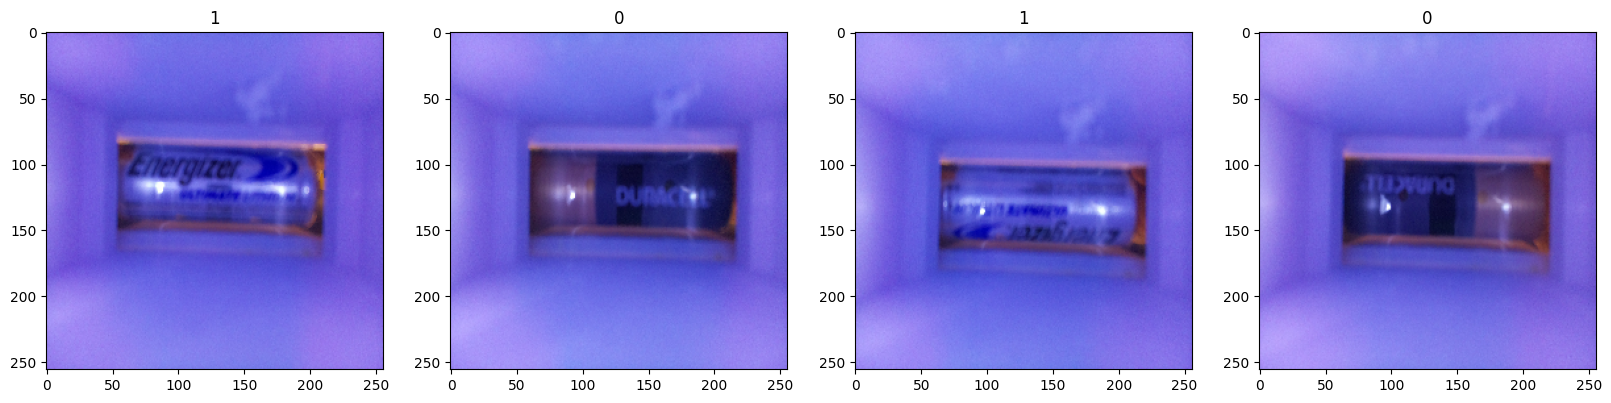

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

<h5><center>In the images above, 0: Duracell Alkaline and 1: Blank and 2: Energizer Lithium</center></h5>

In [43]:
## Split Data
num_batches = len(data)
train_size = int(num_batches*0.6) 
val_size = int(num_batches*0.3)
test_size = int(num_batches*0.1) 

while train_size + val_size + test_size < num_batches:
    test_size += 1

print(f"Train Size: {train_size}, Validation Size: {val_size}, Test Size: {test_size}")
print(f"Number of Batches: {num_batches}")

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


Train Size: 9, Validation Size: 4, Test Size: 3
Number of Batches: 16


### **Deep Model**

#### Building DNN

In [52]:
from tensorflow.keras.models import Sequential, Model # takes only one input as feed and expects one output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

## Adding layers sequentially
# Convulution Layers - using mainly relu activations 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) # Input Layer
model.add(MaxPooling2D()) # Returns max value over (2,2) region, reducing image size by 1/2

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # reduces the input data into a single dimension instead of 2 dimensions.

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # One value as output (0 or 1)


In [53]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.summary()

### Train

In [54]:
path_checkpoint = "training_1/cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)
callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[callback])
# hist.history 

Epoch 1/5


9/9 [==============================] - ETA: 0s - loss: 1.7805 - accuracy: 0.5174

2024-04-05 23:17:07.877944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 1: saving model to training_1/cp.ckpt
9/9 [==============================] - 17s 2s/step - loss: 1.7805 - accuracy: 0.5174 - val_loss: 0.6207 - val_accuracy: 0.5312
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7361

2024-04-05 23:17:24.590967: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 2: saving model to training_1/cp.ckpt
9/9 [==============================] - 17s 2s/step - loss: 0.5639 - accuracy: 0.7361 - val_loss: 0.3761 - val_accuracy: 1.0000
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.9271

2024-04-05 23:17:41.048923: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 3: saving model to training_1/cp.ckpt
9/9 [==============================] - 16s 1s/step - loss: 0.2838 - accuracy: 0.9271 - val_loss: 0.1296 - val_accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9861

2024-04-05 23:17:57.348782: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 4: saving model to training_1/cp.ckpt
9/9 [==============================] - 16s 2s/step - loss: 0.0849 - accuracy: 0.9861 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9965

2024-04-05 23:18:13.764999: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 5: saving model to training_1/cp.ckpt
9/9 [==============================] - 16s 2s/step - loss: 0.0259 - accuracy: 0.9965 - val_loss: 0.0047 - val_accuracy: 1.0000


In [55]:
model.save('alkaline-lithium-model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 62, 62, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 61504)             0         
                                                                 
 dense_8 (Dense)             (None, 256)              

#### Plot Performance

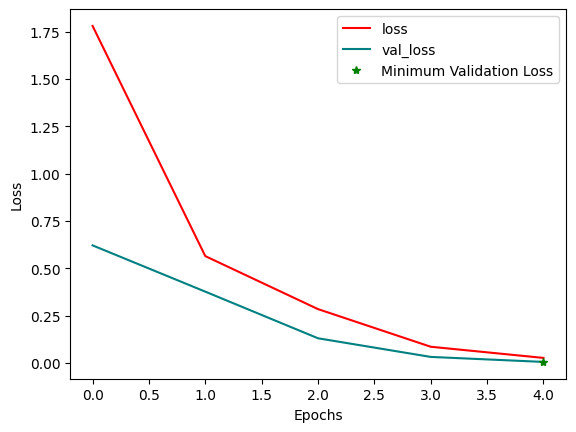

In [56]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label='loss')
plt.plot(hist.history['val_loss'], color = 'teal', label='val_loss')
plt.plot(np.argmin((hist.history['val_loss'])), min(hist.history['val_loss']), color = 'green', label = 'Minimum Validation Loss', marker='*', linestyle = '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()

*Model is overfitting - this will be key in actual sorting*

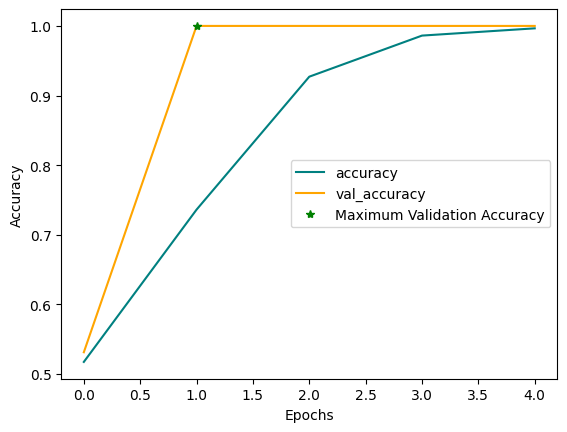

In [57]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(np.argmax((hist.history['val_accuracy'])), max(hist.history['val_accuracy']), color = 'green', label = 'Maximum Validation Accuracy', marker='*', linestyle = '')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="right")
plt.show()

### Evaluate and Test

In [58]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): # testing data
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

print(f"Precision: {pre.result()}")
print(f"Recall: {re.result()}") 
print(f"Accuracy: {acc.result()}")

2024-04-05 23:18:21.005881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 110ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


### Self Testing w/ own images

1/1 [==============================] - 0s 79ms/step
[[0.00713549]]
1/1 [==============================] - 0s 35ms/step
[[0.9969603]]


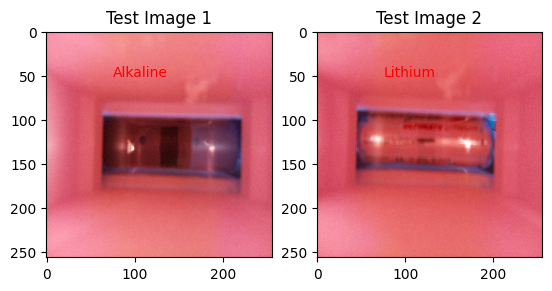

In [60]:
img1 = cv2.imread(os.path.join('user-data', 'image18-0.jpeg'))
img2 = cv2.imread(os.path.join('user-data', 'image2-3.jpeg'))
# im3 = cv2.imread(os.path.join('user-data', 'image18-0.jpeg'))
resize1 = tf.image.resize(img1, (256,256))
resize2 = tf.image.resize(img2, (256,256))
# resize3 = tf.image.resize(img2, (256,256))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(resize1.numpy().astype(int))
axarr[0].set_title('Test Image 1')
axarr[1].imshow(resize2.numpy().astype(int))
axarr[1].set_title('Test Image 2')
# axarr[2].imshow(resize3.numpy().astype(int))
# axarr[2].set_title('Test Image 3')

yhat1 = model.predict(np.expand_dims(resize1/255,0))
print(yhat1)
label1 = 'Alkaline' if yhat1 < 0.5 else 'Lithium'
yhat2 = model.predict(np.expand_dims(resize2/255,0))
print(yhat2)
label2 ='Alkaline' if yhat2 < 0.5 else 'Lithium'

# yhat3 = model.predict(np.expand_dims(resize3/255,0))
# print(yhat3)

# label1 

axarr[0].text(75, 50, label1, color='red')
axarr[1].text(75, 50, label2, color='red')
# axarr[2].text(75, 50, label3, color='red')

plt.show()